# Descriptives

### Preamble

Paths

In [26]:
SYS_PATH = 'C:/Users/mark/Documents/GitHub/honours/dev/package/'
SAVE_PATH = r"C:/Users/mark/Documents/GitHub/honours/submissions/thesis-original"
LOAD_PATH = r"C:/Users/mark/Documents/GitHub/honours/dev/package/analysis/output/temp/output.db"

Imports

In [27]:
#standard imports
import sys
import numpy as np
import pandas as pd
from scipy import stats
from collections import OrderedDict
from datetime import date, timedelta

#third party imports
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib.ticker as ticker
from matplotlib import rcParams
import seaborn as sns

#local imports
sys.path.append(SYS_PATH)
import analysis.dataPreparer as dp
import analysis.autoVC2 as vc

Formatting

In [3]:
%matplotlib inline
TINY_SIZE, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE  = 12, 16, 20, 30
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_palette("colorblind")
rcParams['font.family'] = 'serif' 
rcParams['font.serif'] = 'CMU Serif' 
rcParams['font.weight'] = 'bold'
rcParams['font.size'] = SMALL_SIZE #default font size
rcParams['axes.titlesize'] =SMALL_SIZE   # fontsize of the axes title
rcParams['axes.labelsize'] =MEDIUM_SIZE    # fontsize of the x and y labels
rcParams['xtick.labelsize'] =SMALL_SIZE    # fontsize of the tick labels
rcParams['ytick.labelsize'] =SMALL_SIZE   # fontsize of the tick labels
rcParams['legend.fontsize'] =SMALL_SIZE    # legend fontsize
rcParams['figure.titlesize'] =BIGGER_SIZE  # fontsize of the figure title
rcParams['figure.figsize'] = (8,3)
pd.set_option('precision',3)
outline_bars = dict(linewidth = 1.25, edgecolor = '.15')

In [4]:
STAGE_FEATURES = dict(
    Age = 'confidence_context_economy_company_age_number',
    FundingRounds = 'confidence_validation_funding_rounds_number',
    FundingRaised = 'confidence_validation_funding_raised_value_total_number',
    SeriesA = 'confidence_validation_funding_round_codes_list_a',
    SeriesB = 'confidence_validation_funding_round_codes_list_b',
    SeriesC = 'confidence_validation_funding_round_codes_list_c',
    SeriesD = 'confidence_validation_funding_round_codes_list_d',
    SeriesE = 'confidence_validation_funding_round_codes_list_e',
    SeriesF = 'confidence_validation_funding_round_codes_list_f',
    SeriesG = 'confidence_validation_funding_round_codes_list_g',
    SeriesH = 'confidence_validation_funding_round_codes_list_h',
    Closed = "keys_company_status_closed_bool",
    Acquired = "keys_company_status_acquired_bool",
    IPO = "keys_company_status_ipo_bool")

Functions

In [30]:
def load_data(path=LOAD_PATH):
    data = vc.prepare_dataset(
        SYS_PATH + "analysis/input/master.db", date(2016, 9, 9),
        SYS_PATH + "analysis/config/master_feature.sql", "feature",
        SYS_PATH + "analysis/output/temp/", alt=True)
    data = vc.add_stages(data)
    return data

In [6]:
def auto_label(ax, fmt='{:,.0f}', adjust=0):
    ymax_old = ax.get_ylim()[1]
    ax.set_ylim(ymax= ax.get_ylim()[1] * 1.1)
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x()+p.get_width()/2.,
            y=np.nanmax([height,0]) + ymax_old * 0.02 + adjust,
            s=fmt.format(np.nanmax([height,0])),
            ha="center")
    ax.yaxis.set_ticks([])

In [7]:
def add_vertical_line(ax, value, label, color, linestyle="dashed"):
    ax.axvline(value, linestyle=linestyle, color=color)
    x_bounds = ax.get_xlim()
    xy_pos = (((value-x_bounds[0])/(x_bounds[1]-x_bounds[0])),1.01)
    ax.annotate(s=label, xy =xy_pos, xycoords='axes fraction', verticalalignment='right', horizontalalignment='right bottom', color=color)

### Counts by developmental stage

In [8]:
reload = True

In [9]:
chart_id = "figures/design/descriptives_counts_stage"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [10]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = load_data()
    data = data[["keys_company_stage"]]
    data.to_pickle(pickle_path)

In [11]:
x = "keys_company_stage"
order = ["Pre-Seed", "Seed", "Series A", "Series B", "Series C", "Series D+", "IPO", "Acquired"]

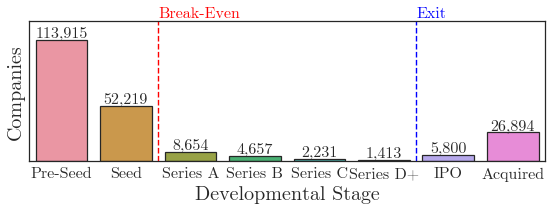

In [12]:
f = plt.figure()
ax = sns.countplot(data=data, x=x, order=order, **outline_bars)
auto_label(ax)
add_vertical_line(ax, 1.5, "Break-Even", color="r")
add_vertical_line(ax, 5.5, "Exit", color="b")
ax.set_xlabel("Developmental Stage")
ax.set_ylabel("Companies")
plt.tight_layout()

In [13]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Counts by industry sector

In [23]:
reload = True

In [24]:
chart_id = "figures/design/descriptives_counts_industry"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [32]:
try:
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = load_data()
    data = data.loc[data['keys_company_stage_group'] == "Included"]
    cutoff = data["confidence_context_economy_company_age_number"][data["keys_company_stage"] == "Series D+"].quantile(0.75)
    data = data.loc[data['confidence_context_economy_company_age_number'] <= cutoff]
    data = data[[x for x in list(data) if x.startswith("confidence_context_industry_category_group_list")]]
    data.to_pickle(pickle_path)

logManager - INFO - prepare_dataset | Started
logManager - INFO - get_slice | Started
logManager - INFO - get_slice | Passed | 0.28
logManager - INFO - prepare_dataset | Passed | 24.95
logManager - INFO - add_stages | Started
logManager - INFO - add_stages | Passed | 39.13


In [33]:
x = ["Software", "Internet", "Media", "Commerce", "Mobile", "Sales", "IT", "Health", "Hardware", "Financial"]
y = sorted([data[industry].value_counts()[1] for industry in list(data)],reverse=True)

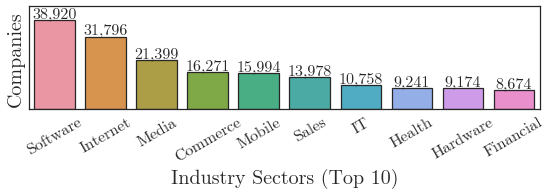

In [34]:
f = plt.figure()
ax = sns.barplot(data=None, x=x, y=y, **outline_bars)
auto_label(ax)
plt.xticks(rotation=30)
ax.set_ylabel("Companies")
ax.set_xlabel("Industry Sectors (Top 10)")
plt.tight_layout()

In [35]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Ages by developmental stage

In [36]:
reload = True

In [37]:
chart_id = "figures/design/descriptives_ages_stage"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [39]:
try:
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = load_data()
    data = data.loc[data['keys_company_stage_group'] == "Included"]
    data = data[["confidence_context_economy_company_age_number","keys_company_stage"]]
    data.to_pickle(pickle_path)

logManager - INFO - prepare_dataset | Started
logManager - INFO - get_slice | Started
logManager - INFO - get_slice | Passed | 0.18
logManager - INFO - prepare_dataset | Passed | 25.17
logManager - INFO - add_stages | Started
logManager - INFO - add_stages | Passed | 47.64


In [41]:
x = "confidence_context_economy_company_age_number"
y = "keys_company_stage"
order = ["Pre-Seed", "Seed", "Series A", "Series B", "Series C", "Series D+"]
line = data[x][data[y] == "Series D+"].quantile(0.75)

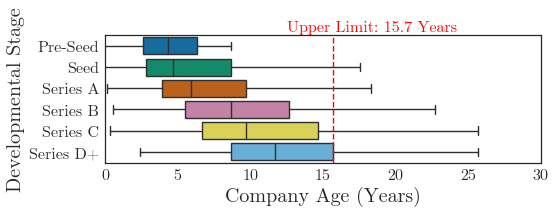

In [42]:
f = plt.figure()
ax = sns.boxplot(data=data, x=x, y=y, order=order, fliersize=0)
add_vertical_line(ax, line, "Upper Limit: {:.1f} Years".format(line), color="r")
ax.set_xlim(xmin=0, xmax=30)
ax.set_xlabel("Company Age (Years)")
ax.set_ylabel("Developmental Stage")
plt.tight_layout()

In [43]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Overall by developmental stage

In [44]:
reload = False

In [45]:
chart_id = "tables/design/descriptives_overall_stage"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [47]:
try:
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = load_data()
    data = data.loc[data['keys_company_stage_group'] == "Included"]
    cutoff = data["confidence_context_economy_company_age_number"][data["keys_company_stage"] == "Series D+"].quantile(0.75)
    data = data.loc[data['confidence_context_economy_company_age_number'] <= cutoff]
    drops = [col for col in list(data) if col.startswith(("key","from","outcome","index"))]
    X = data.drop(drops, axis=1)
    X = X.select_dtypes(['number'])
    data["keys_missing_features"] = X.isnull().sum(axis=1)
    data["total_features"] = len(list(X))
    data = data[["keys_company_stage", "confidence_context_economy_company_age_number", "confidence_validation_funding_raised_value_total_number", "confidence_validation_funding_rounds_number", "potential_structural_patents_number", "keys_missing_features", "total_features", "keys_company_stage_group"]]
    data.to_pickle(pickle_path)

logManager - INFO - prepare_dataset | Started
logManager - INFO - get_slice | Started
logManager - INFO - get_slice | Passed | 0.20
logManager - INFO - prepare_dataset | Passed | 26.09
logManager - INFO - add_stages | Started
logManager - INFO - add_stages | Passed | 41.97


In [55]:
data["keys_company_stage2"] = data["keys_company_stage"]
columns = ["keys_company_stage", "confidence_context_economy_company_age_number", "confidence_validation_funding_raised_value_total_number", "confidence_validation_funding_rounds_number", "potential_structural_patents_number", "keys_missing_features"]
colnames = ["Obs", "Age (Years)", "Funding Raised (USD, millions)", "Funding Rounds (N)","Patent Filings (N)", "Available Features (N)"]
colfuncs = [{"N":len}, 
    OrderedDict([("Median", np.median),("IQR", lambda x: stats.iqr(x,nan_policy="omit"))]), 
    OrderedDict([("Median", lambda x: np.median(x) / 1e6), ("IQR", lambda x: stats.iqr(x,nan_policy="omit") / 1e6)]), 
    OrderedDict([("Median", np.median),("IQR", lambda x: stats.iqr(x,nan_policy="omit"))]), 
    OrderedDict([("50th", np.median),("75th", lambda x: np.nanpercentile(x,75)),("90th", lambda x: np.nanpercentile(x,90))]), 
    OrderedDict([("Median", lambda x: data["total_features"].sample(1).values[0] - np.median(x)), ("IQR", lambda x: stats.iqr(x,nan_policy="omit") )])]
namefunc = OrderedDict(zip(columns, colnames))
aggfunc = OrderedDict(zip(columns, colfuncs))

In [56]:
pivot1 = pd.pivot_table(data, values=columns, index="keys_company_stage2", aggfunc=aggfunc,  fill_value = 0,  margins=False)
pivot2 = pd.pivot_table(data, values=columns, index="keys_company_stage_group", aggfunc=aggfunc, fill_value = 0, margins=False)
table = pd.concat([pivot1,pivot2],axis=0).rename(columns=namefunc)
table

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1043: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


Obs Age (Years)        Funding Raised (USD, millions)          \
                N         IQR Median                            IQR  Median   
Pre-Seed   113915       3.737  4.362                          0.000   0.000   
Seed        38942       4.003  4.663                          1.295   0.250   
Series A     6615       5.005  5.693                          7.906   4.400   
Series B     3342       5.918  7.608                         22.032  14.891   
Series C     1610       5.523  8.696                         45.881  35.285   
Series D+     998       5.005  9.696                         90.300  74.385   
Included   165422       4.003  4.688                          3.970   0.000   

          Funding Rounds (N)        Patent Filings (N)            \
                         IQR Median               50th 75th 90th   
Pre-Seed                   0      0                  0    0    0   
Seed                       1      1                  0    0    1   
Series A                   2      2                  0    0    2   
Series B                   2      3                  0    0    4   
Series C                   2      3                  0    1    9   
Series D+                  3      5                  0    4   19   
Included                   1      1                  0    0    1   

          Available Features (N)         
                             IQR Median  
Pre-Seed                   128.0     25  
Seed                       125.0    178  
Series A                   117.5    239  
Series B                    87.0    255  
Series C                    80.0    305  
Series D+                   69.0    319  
Included                   145.0     90

In [57]:
output_path =  "{}/{}.tex".format(SAVE_PATH, chart_id)
table.to_latex(output_path)